## 2 모델 적용 


### 2.1 구글 Multilingual BERT 


&nbsp;&nbsp;  ■ 참고 문서 : 1)[BERT with the huggingface PyTorch library](https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification) 
            2)[transformers/text-classification](https://github.com/huggingface/transformers/tree/master/examples/text-classification) \
&nbsp;&nbsp;  ■ 논문 : [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)
    
   * 작년 PO부서의 77.9% 모델은 <code>Google Multilingual-BERT</code>를 사용한 정확도 였습니다.
   * 첫 시작으로 동일하게 구글 버트를 선 적용해보고 비슷한 정확도를 산출해보면서, 버트를 사용하는 방법을 익혀보았습니다.

> **BERT 에 대한 간단한 소개** \
BERT(Bidirectional Encoder Representations from Transformers)는 구글이 개발한 사전훈련(pre-training) 모델입니다. \
위키피디아 같은 대량의 텍스트 코퍼스를 사용해서 미리 학습을 하게 되면, 언어의 기본적인 패턴을 이해한 모델이 만들어집니다. \
이를 기반으로 새로운 문제에 적용하는 전이학습(transfer learning)을 수행합니다. \
\
문제를 해결하기 위해 처음부터 학습을 시작하지 않고, 적은 데이터와 훨씬 적은 시간을 들여 학습 결과를 얻을 수 있다는 장점이 있습니다. \
또 전이학습(transfer learning)방법이 최근 다양한 NLP 문제에서 기존 TOP-1 성능을 앞지르며 핵심 기법으로 떠오르고 있습니다. \
아래 구현하게 될 bert모델 적용은 구글에서 공개한 사전훈련(pre-training)된 모델을 가져와 특정 NLP task를 해결하는 목적의 fine-tuning 을 시행하는 것입니다. \
즉, pretrained BERT 모델에 텍스트 분류(text-classification)를 위한 마지막 neural layer(FC)를 얹고 전체 모델을 미세조정하는 것입니다. 


<br><br>
#### (1) 환경 설치 및 라이브러리 임포트 
- transformers 설치 
- [파이토치 설치 (설치환경별 코드 상이)](https://pytorch.org/)


In [1]:
# Installing the Hugging Face Library
# !pip install transformers

In [1]:
import pandas as pd
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# GPU 사용 지정
if torch.cuda.is_available():    
    # GPU를 사용하라고 지시    
    device = torch.device('cuda')

# If not... CPU 사용 지정
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

<br><br>
#### (2) 데이터 로딩
- 1_intro 에서 데이터 전처리 후 최종 저장한 <code>data/train_data.tsv</code>, <code>data/test_data.tsv</code> 불러옵니다.
- 각 데이터는 label(예측해야할 값)과 text(예측에 사용될 값)로 이루어져 있습니다.

In [4]:
# Load the dataset 
train = pd.read_csv("data/train_data.tsv", sep ='\t', header=0, encoding='utf-8', names=['label','text'])
test = pd.read_csv("data/test_data.tsv", sep ='\t', header=0, encoding='utf-8', names=['label','text'])

# sentences 개수
print('Training sentences 개수: {:,}\n'.format(train.shape[0]))
print('Test sentences 개수: {:,}\n'.format(test.shape[0]))

# 랜덤한 10개 샘플 출력
train.sample(10)

Training sentences 개수: 34,396

Test sentences 개수: 8,327



,label,text
31185,ASM38849,단말기 수수료지급이력 문의 단말기 수수료지급이력 문의 교품
10346,ASM31686,일반전화 미처리재개요청중인 명령 현장작업 공정으로 진행 안됨 경로 서비스수행 명령현...
2234,ASM24660,각 시스템별 월 접속로그 안녕하세요 kt ds 그룹사업 팀 심재화입니다 정보보안 시...
22105,ASM38549,업무지원요청 srm scap shub voc 업무 요청 otm 쿠폰 지급 관련 상용...
21522,ASM14351,조직변경으로 구문서 이동 방법문의 조직변경으로 구문서 이동 방법문의 황현석 현재 문...
31297,ASM30565,요금제 해지시 가입비 면제사유가 결합으로 대체되어 가입비 면제가 유지되는지 문의드립...
12270,ASM31972,zpsrp 선로 관로 물자철거관리에서 반려 상태로 확인되나 톰스에서는 조회가 안되어...
21937,ASM38948,신규개통진행중 번호채번시 해당 전화번호는 발생되어 문의 선 검토내역 경로 데이터 손...
6960,ASM30229,mvno dlp 실행이 안되는 문의 실행이 안되는 문의 문의자 이도연 연락처 바로가...
26943,ASM31688,중복오더 무출동 완료보고시 단말처리 방법 문의 경로 서비스수행 주문정보조회 데이터 ...


In [5]:
# text 와 label을 리스트로 가져옵니다.
train_texts = train.text.values.tolist()
train_labels = train.label.values.tolist()

test_texts = test.text.values.tolist()
test_labels = test.label.values.tolist()

train_texts[:2] , train_labels[:2]

(['고객님 정보 확인 불가 문의 안녕하세요 당일 고객님 분실정지 진행하려고 하는데 인입시 고객정보가 조회되지 않습니다 처리결과 값이 올바르지 않습니다 라고 나오면 정보조회의 기본정보 성명 생년월일등 가 확인되지 않습니다 해당 내용 확인 부탁 드립니다 감사합니다',
  '긴급 tv m oss 결과보고시 기존바코드 확인안되어hds연동할수 없음 업무경로 데이터 국사 원주 회선번호 수리접수번호 상품정보 서비스계약번호 연락처 이윤범 현장 확인사항 수리오더로 결과보고시 연동시 기존바코드가 올라오지않아 교체업무 진행을 할 수 가 없습니다 완료보고 확인시 기존바코드에 빌트인 로 확인되며 단말원부확인시 댁내설치된기존바코드 확인시 사용 사용으로 되어 있습니다 긴급건으로 확인 및 조치 부탁 드립니다'],
 ['ASM34824', 'ASM31688'])

<br><br>
#### (3) 데이터 포맷 변경 - 1. label (Output y) 정수 인덱싱
- label 을 문자 string 에서 int형 정수로 매핑합니다. 

In [6]:
print('test data의 label 개수 :',len(set(test.label.values.tolist())))
print('test data의 label 예시 :',list(sorted(set(test.label.values.tolist())))[:3])

# 라벨별 정수 인덱스화  
label_idx = {j:i for i,j in enumerate(sorted(set(test.label.values.tolist())))} # dict{ 'ASM14261' : 0 , 'ASM14262' : 1 , ...} 
print('\nlabel 인덱스(label_idx) 개수 :',len(label_idx))
print('label 인덱스(label_idx) 예시 :',[v for idx, v in label_idx.items()][:3])

train_labels = [label_idx[i] for i in train.label.values.tolist()]
test_labels = [label_idx[i] for i in test.label.values.tolist()]

print('\nTrain Data 개수 :',len(train_labels) , '\nTest Data 개수 :',len(test_labels))
print('\n▶label 정수 인덱스화 예시 :' , train.label.values.tolist()[:3], '->', train_labels[:3] )

test data의 label 개수 : 183
test data의 label 예시 : ['ASM14261', 'ASM14262', 'ASM14263']

label 인덱스(label_idx) 개수 : 183
label 인덱스(label_idx) 예시 : [0, 1, 2]

Train Data 개수 : 34396 
Test Data 개수 : 8327

▶label 정수 인덱스화 예시 : ['ASM34824', 'ASM31688', 'ASM30157'] -> [102, 93, 79]


<br><br>
#### (4) 데이터 포맷 변경 - 2. text (Input x) 토큰화 및 정수 인덱싱
- BERT를 학습 할 수 있는 형식으로 데이터 포맷을 변환합니다. \
  . 문장별 토큰화 \
  . vocab 기반 정수 인덱스 매핑 & padding \
  . input text mask 적용 
- 토큰화는 BERT에 내장된 Tokenizer에 의해 수행됩니다.

#### (4-1) 토큰화 예시

In [7]:
from transformers import BertTokenizer, AutoTokenizer

# Load the BERT tokenizer.
print('BERT tokenizer 다운로드 ..')
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True) 

BERT tokenizer 다운로드 ..


In [8]:
# 예시) 원본 text를 출력 
print('train data 원본 문장: ', train_texts[0])

# 예시) 문장을 토큰화 적용 
print('\n토큰화 적용: ', tokenizer.tokenize(train_texts[0]))

# 예시) 문장의 토큰을 token ids(정수)로 매핑한 결과 출력
print('\nToken ids 적용: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_texts[0])))

train data 원본 문장:  고객님 정보 확인 불가 문의 안녕하세요 당일 고객님 분실정지 진행하려고 하는데 인입시 고객정보가 조회되지 않습니다 처리결과 값이 올바르지 않습니다 라고 나오면 정보조회의 기본정보 성명 생년월일등 가 확인되지 않습니다 해당 내용 확인 부탁 드립니다 감사합니다

토큰화 적용:  ['고', '##개', '##ᆨ', '##니', '##ᆷ', '정', '##보', '확인', 'ᄇ', '##ᅮᆯ', '##가', 'ᄆ', '##ᅮᆫ', '##의', 'ᄋ', '##ᅡᆫ', '##녀', '##ᆼ', '##하', '##세', '##요', '다', '##ᆼ이', '##ᆯ', '고', '##개', '##ᆨ', '##니', '##ᆷ', 'ᄇ', '##ᅮᆫ', '##실', '##정', '##지', '진', '##행', '##하', '##려', '##고', '하는', '##데', '인', '##입', '##시', '고', '##개', '##ᆨ정', '##보', '##가', 'ᄌ', '##ᅩ', '##회', '##되지', 'ᄋ', '##ᅡ', '##ᆭ', '##스', '##ᆸ니다', 'ᄎ', '##ᅥ리', '##결', '##과', '가', '##ᆹ', '##이', 'ᄋ', '##ᅩᆯ', '##바', '##르', '##지', 'ᄋ', '##ᅡ', '##ᆭ', '##스', '##ᆸ니다', '라고', 'ᄂ', '##ᅡ', '##오', '##면', '정', '##보', '##조', '##회의', 'ᄀ', '##ᅵ', '##본', '##정', '##보', '성', '##명', '새', '##ᆼ', '##년', '##월', '##일', '##드', '##ᆼ', '가', '확인', '##되지', 'ᄋ', '##ᅡ', '##ᆭ', '##스', '##ᆸ니다', '해당', '내', 

<br><br> 
#### (4-2) 토큰화 길이 지정 (max_len)
- **문장들은 다양한 길이를 가지고 있는데 BERT는 이를 어떻게 처리할까요?**
>BERT 는 2가지 제약이 있습니다 :
>1. 모든 문장은 하나의 고정 길이로 갖고 모델에 들어갑니다. \
>2. 버트에서 허용된 최대 문장 길이는 **512** 토큰입니다.


- 데이터 내 문장의 **최대 토큰 길이**를 살펴보겠습니다. 

In [12]:
train_len = []
test_len = []

# Train 모든 문장 검색
for sent in train_texts:
    # text 토큰화 및 `[CLS]` and `[SEP]` 토큰 추가.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # 최대문장길이 저장.
    train_len.append(len(input_ids))

# Test 모든 문장 검색
for sent in test_texts:
    # text 토큰화 및 `[CLS]` and `[SEP]` 토큰 추가.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # 최대문장길이 저장.
    test_len.append(len(input_ids)) 
    
print('train 문장 중 최대 토큰 길이 :', max(train_len))
print('test 문장 중 최대 토큰 길이 :', max(test_len))

train 문장 중 최대 토큰 길이 : 1807
test 문장 중 최대 토큰 길이 : 1847


- max_len 값 지정을 위해, 문장 길이 별 히스토그램 분포를 통해 확인해 보도록 하겠습니다.

train data 토큰길이 <= 512 :,  98.71 %
train data 토큰길이 <= 256 :,  85.9 %

test data 토큰길이 <= 512 :,  98.87 %
test data 토큰길이 <= 256 :,  85.54 %

▶ max_len = 256 으로 잡았을 때, 전체 문장의 86.0 % 가 256보다 적은 토큰을 가지고 있습니다.



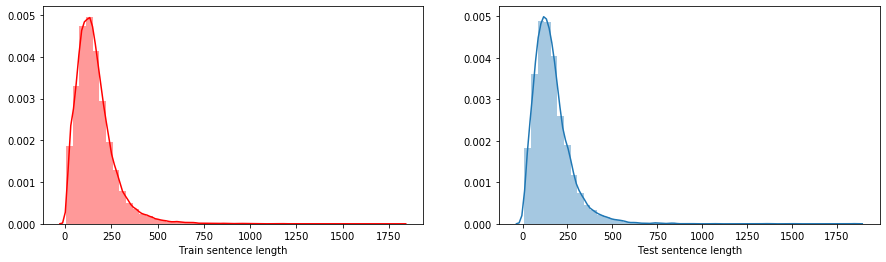

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns 

f, axes = plt.subplots(1, 2, figsize=(15, 4))
fig_1 = sns.distplot(train_len,ax=axes[0],color="red",axlabel='Train sentence length')
fig_2 = sns.distplot(test_len,ax=axes[1],axlabel='Test sentence length')

# train data 내 문장의 길이가 512/300 보다 적은 건수 카운팅
print('train data 토큰길이 <= 512 :, ', round(len([x for x in train_len if x<=512])/len(train_len)*100,2),'%')
print('train data 토큰길이 <= 256 :, ', round(len([x for x in train_len if x<=256])/len(train_len)*100,2),'%')

# test data 내 문장의 길이가 512/300 보다 적은 건수 카운팅
print('\ntest data 토큰길이 <= 512 :, ', round(len([x for x in test_len if x<=512])/len(test_len)*100,2),'%')
print('test data 토큰길이 <= 256 :, ', round(len([x for x in test_len if x<=256])/len(test_len)*100,2),'%')

print('\n▶ max_len = 256 으로 잡았을 때, 전체 문장의', round(len([x for x in train_len if x<=256])/len(train_len)*100,0),'% 가 256보다 적은 토큰을 가지고 있습니다.\n' )


<br><br>
#### (4-3) 전체 train text 토큰화

1. 문장을 토큰 단위로 나눕니다.
2. 문장마다 스페셜 토큰인 [CLS] 와 [SEP] 토큰을 추가합니다.
3. 토큰을 해당 ID(정수값)로 매핑합니다.
4. 문장을 같은 길이(max_len=256)로 자르고, 256보다 작은 문장은 0으로 채웁니다.(padding)
5. 정수값으로 매핑된 토큰과 padding으로 채워진 0토큰을 구별하는 attention mask를 만듭니다. 


In [8]:
# Train data 문장 토큰화 및 정수 인덱스(ids) 매핑 , 패딩 시행


def indexing(texts , labels, max_len=128):
    input_ids = []
    attention_masks = []

    # 토큰화 시행
    for sent in texts:
        encoded_dict = tokenizer.encode_plus(
                            sent,                       # 문장 단위로 입력
                            truncation=True,
                            add_special_tokens = True,  # '[CLS]' 와 '[SEP]' 토큰 추가 
                            max_length = max_len,           # 문장 길이를 256 까지 자르고, 빈곳은 0으로 채웁니다.
                            pad_to_max_length=True,
                            return_attention_mask = True, # 5번 attention_mask 를 생성합니다. 
                            return_tensors = 'pt',      #  pytorch tensors 형태로 출력합니다.
                       )

        # 정수인코딩 된 문장을 리스트로 생성   
        input_ids.append(encoded_dict['input_ids'])

        # attention mask 생성
        attention_masks.append(encoded_dict['attention_mask'])

    # 리스트를 토치 텐서로 바꾸기
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids , attention_masks , labels

input_ids , attention_masks , labels = indexing(train_texts, train_labels, 128)
    
# 문장 예시 : 
print('원본 예시: ', train_texts[0])
print('\n토큰화 시행 후:', input_ids[0])

# 토큰길이가 128보다 적은 경우 나머지를 0으로 채워집니다.(padding)

/home/bj1123/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


원본 예시:  고객님 정보 확인 불가 문의 안녕하세요 당일 고객님 분실정지 진행하려고 하는데 인입시 고객정보가 조회되지 않습니다 처리결과 값이 올바르지 않습니다 라고 나오면 정보조회의 기본정보 성명 생년월일등 가 확인되지 않습니다 해당 내용 확인 부탁 드립니다 감사합니다

토큰화 시행 후: tensor([  101, 47468, 22123, 12756, 25536, 13503, 81463, 27884, 80080,  1170,
        65633, 11376,  1169, 45554, 10576,  1174, 26646, 49345, 13045, 35132,
        25169, 47024, 84186, 41192, 12397, 47468, 22123, 12756, 25536, 13503,
         1170, 45554, 31376, 17861, 12799, 87550, 26617, 35132, 26733, 12300,
        24299, 26872, 77073, 62776, 14280, 47468, 22123, 81780, 27884, 11376,
         1175, 29347, 15190, 56627,  1174, 25539, 97096, 13212, 79427,  1177,
        82108, 70870, 12211, 20966, 97103, 11112,  1174, 73057, 41040, 30716,
        12799,  1174, 25539, 97096, 13212, 79427, 31584,  1165, 25539, 27901,
        15463, 81463, 27884, 20766, 54418,  1163, 32035, 55030, 17861, 27884,
        52250, 16961, 88678, 13045, 11084, 38270, 21175, 15970, 13045, 20966,
        80080, 56627,  1174, 25539, 97096, 13212, 79427, 

<br><br>
#### (5) train data의 분리 - Training & Validation data Split
- Training data와 Validation data를 9:1이 되도록 Training set을 나눕니다.

In [9]:
from torch.utils.data import TensorDataset, random_split

# TensorDataset를 사용하여 input 통합
dataset = TensorDataset(input_ids, attention_masks, labels)

# train-validation 9:1 사이즈로 갯수 저장 
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# random하게 데이터셋 분리 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('training data : {:>5,} '.format(train_size))
print('validation data : {:>5,} '.format(val_size))

training data : 30,956 
validation data : 3,440 


<br><br>
#### (6) 데이터 로더 build 
- 학습시 배치 사이즈로 진행될 수 있도록 DataLoader 를 사용 

In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# 배치크기를 지정합니다. 
batch_size = 32

# DataLoaders 를 사용하여 학습시 배치사이즈로 모델에 들어갈 준비합니다.
# train_dataloader 생성
train_dataloader = DataLoader(
            train_dataset,  # training data
            sampler = RandomSampler(train_dataset), # 배치 데이터가 랜덤하게 들어갑니다.
            batch_size = batch_size # 배치 사이즈 지정
        )

# validation_dataloader 생성 
validation_dataloader = DataLoader(
            val_dataset, # validation data
            sampler = SequentialSampler(val_dataset), # 랜덤할 필요가 없기 때문에 시퀀셜하게 배치 데이터가 들어갑니다.
            batch_size = batch_size # 배치 사이즈 지정
        )

<br><br>
#### (6) BERT Model 가져오기
- 학습에 필요한 데이터 포맷이 준비 되었기 때문에, BERT 모델을 Fine-tuning 하도록 합니다.
- 사전 학습 된 BERT 모델을 가져온 후, 분류 목적(Classification Task)을 위한 최종 모델을 구성한 후 training data를 이용해 모델의 전체 파라메터를 미세조정하는 학습을 진행합니다.
- (최종 NLP task 목적에 따라 쓰이는 모델이 다르며 자세한 내용은 [이곳](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html)에서 확인 가능합니다.)
- 여기서 사용하게 되는 분류를 위한 버트 모델은 <code>BertForSequenceClassification</code> 입니다. \
문장 분류를 위해 위에 단일 선형 레이어가 추가된 일반 BERT 모델입니다. \
즉, 사전 훈련 된 전체 BERT 모델(encoder)과 훈련되지 않은 추가 분류 레이어(fc)가 training data를 이용해 파인튜닝됩니다.

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassification을 가져오면, the pretrained BERT model 과 상단에 단일 linear classification layer가 있는 모델이 로드됩니다.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # multilingual 다국어버전 모델 로드
    num_labels = 183, # 183개의 레이블의 정답을 맞춰야 하는 classification task
    output_attentions = False, # 모델의 attentions weights를 반환할 것인지 여부
    output_hidden_states = False, # 모델의 모든 hidden-states를 반환할 것인지 여부
)

# pytorch에게 GPU에서 모델을 실행하도록 지시.
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [12]:
# 모델의 parameters를 리스트로 출력해 봅니다.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

* 마지막 Output Layer가 분류 목적을 위한 추가된 레이어에 해당합니다.

<br><br>
#### (7) Optimizer & Learning Rate Scheduler 지정하기
- 모델이 로드 되었으므로, training을 위한 적절한 하이퍼 파라미터를 가져와야합니다. 
- BERT 논문의 부록 A.3에 따르면, fine-tuning 시 다음과 같은 hyperparameters를 선택하는 것을 추천하고 있습니다.(Appendix A.3 참고 [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
>- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
>- **Number of epochs:** 2, 3, 4 


ㅇ 선택한 하이퍼파라미터:
* Batch size: 16,32 
* Learning rate: 5e-5 , 2e-5 
* Epochs: 6 이상 (valid loss가 epoch 4를 넘어 계속 낮아지기에 선택)

참고 : `run_glue.py`의 AdamW, num_warmup_steps 값 [참고](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [13]:
# optimizer 를 지정합니다.
learning_rate = 5e-5

no_decay = ['bias', 'LayerNorm.weight']

# `weight` 매개 변수와 `bias` 매개 변수를 분리합니다.
# - `weight` 매개 변수의 경우 0.01의 'weight_decay_rate'를 지정합니다.
# - 'bias'매개 변수의 경우 'weight_decay_rate'는 0.0로 지정합니다.
optimizer_grouped_parameters = [
    # 'bias', 'gamma', 'beta'를 포함하지 않는 모든 매개 변수를 필터링합니다.
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    
    # 포함하는 매개 변수를 필터링합니다.
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(model.parameters(), # optimizer_grouped_parameters
                  lr = learning_rate, # learning_rate로 기본값은 5e-5
                  eps = 1e-8 # adam_epsilon로 기본값은 1e-8. # 엡실론 매개 변수 eps = 1e-8은 학습시 0으로 나누는 것을 방지하기 위한 매우 작은 숫자입니다.
                )

In [14]:
from transformers import get_linear_schedule_with_warmup

# 학습 epoch 수 지정
# 논문에서는 최대 4 까지 쓰는 것을 추천했지만, val loss가 계속 떨어지기 때문에 epoch을 늘렸습니다.
epochs = 8

# 전체 training steps는 [batch 개수] x [epoch 개수]. 
total_steps = len(train_dataloader) * epochs

# learning rate scheduler를 만듭니다.
warmup_step = 0
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_step, # 기본값은 0 이고 학습시 조정 대상
                                            num_training_steps = total_steps)

<br><br>
#### (8) 모델 학습
- Train data 와 Validation data 을 사용하여 학습과 검증을 시행합니다. 
- Pytorch 에서 Training 하는 방법에 대해 해당 [예시](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)를 참고

#### training 시작! 

■ 실험 요약
- 실험1 : max_length = 128 , batch_size = 64 , lr = 2e-5 
- 실험2 : max_length = 128 , batch_size = 64 , lr = 5e-5 
- 실험3 : max_length = 256 , batch_size = 32 , lr = 5e-5 
- 실험4 : max_length = 512 , batch_size = 16 , lr = 5e-5 
- 실험5 : max_length = 256 , batch_size = 32 , lr = 5e-5 , warmup_step=10

> 실험 결과를 종합하여 최적의 하이퍼 파라미터를 선정하게 되고, 
> 이후 validation set 없이 전체 데이터를 train data로 넣어 최종 모델을 산출 할 예정입니다.

※ 아래 학습을 위한 구체적 코드 참고는 `run_glue.py` ([클릭](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128))

※ 다양한 하이퍼 파라미터 실험을 위해 `class Train:` 을 만들어 training에 적용하였습니다.

In [15]:
import numpy as np

# 예측값 과 정답 간 일치 여부에 대한 '정확도'를 계산하는 함수 
# validation accuracy 에서 실시
def flat_acc_sum(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    correct = np.sum(pred_flat == labels_flat)
    n = len(labels_flat)
    return correct, n 

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
import time
import datetime

# 경과 시간을 hh : mm : ss 형식으로 표현하는 함수
def format_time(elapsed):
    '''
    hh:mm:ss(시간:분:초)로 걸린 시간을 환산합니다.
    '''
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss 포맷화
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
 
class Trainer:
    def __init__(self, lr=5e-5, batch_size=16 , epochs = 6, max_len = 256, warmup_step = 0):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.max_len = max_len
        self.warmup_step = warmup_step
        
        # 모델 다운로드
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-multilingual-uncased", 
            num_labels = 183, 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda()

        # train data 인풋포맷
        input_ids , attention_masks , labels = indexing(train_texts , train_labels, max_len)
        
        # TensorDataset를 사용하여 input 통합
        dataset = TensorDataset(input_ids, attention_masks, labels)
 
        # train-validation 9:1 사이즈로 갯수 저장 
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size
        
        # 데이터셋 분리 
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_dataloader = DataLoader(
                    train_dataset,  # training data
                    sampler = RandomSampler(train_dataset),
                    batch_size = batch_size
                )
        validation_dataloader = DataLoader(
                    val_dataset, # validation data
                    sampler = SequentialSampler(val_dataset), 
                    batch_size = batch_size
            )       
        optimizer = AdamW(model.parameters(), #optimizer_grouped_parameters,
                  lr = lr, 
                  eps = 1e-8 
                )
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = warmup_step, # 기본값은 0 이고 학습시 조정 대상
                                                    num_training_steps = total_steps)
    def train(self):
        # 시드설정
        seed_val = 42
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # training and validation loss 값을 저장합니다. 
        training_stats = []
        avg_loss = []

        #전체 학습/평가 시간을 측정합니다.
        total_t0 = time.time()
        
        # 설정 print
        print(f"config : max_len={self.max_len}, batch_size={self.batch_size}, lr={self.lr}, epochs = {self.epochs}, warmup_step={self.warmup_step} ")

        # 각 에포크 시 실행
        for epoch_i in range(0, self.epochs):
            # =====================================================================================
            #         Training     
            # =====================================================================================
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, self.epochs))
            print('Training : ')

            # training 시간 측정
            t0 = time.time()

            # epoch시작 마다 total loss 리셋
            total_train_loss = 0

            # 모델을 훈련 모드로 전환 (pytorch는 training모드인지 evaluation모드인지 지정하여야 함)
            model.train()

            # 각 배치별 훈련 실행
            for step, batch in enumerate(train_dataloader):
                if step % 500 == 0 and not step == 0:
                    # 경과 시간을 분 단위로 계산
                    elapsed = format_time(time.time() - t0)
                    # 진행 사항 출력
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # 이전에 계산 된 그라디언트를 지웁니다.
                model.zero_grad()        

                # forward 기능을 수행합니다.
                # BertForSequenceClassification 모델의 아웃풋 형식 참조
                loss, logits = model(b_input_ids, 
                                     token_type_ids=None, 
                                     attention_mask=b_input_mask, 
                                     labels=b_labels)

                # 모든 배치에 대한 훈련 손실을 누적합니다.
                # `.item ()`함수를 이용해 텐서에서 파이썬 값으로 반환합니다.
                # 마지막에 평균 손실을 계산하게 됩니다.
                total_train_loss += loss.item()

                # 그레디언트(기울기) 계산을 위해 backward() 수행합니다.
                loss.backward()

                # 그레디언트를 1.0.로 한정하여
                # "그라데이션 폭발" 문제를 방지하도록 합니다.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # the learning rate 등을 참조하여 
                # 계산 된 기울기의 일정 부분을 한 스텝으로 움직여 매개 변수를 업데이트 합니다.
                optimizer.step()

                # learning rate를 업데이터 합니다. (점점 줄어드는 decay 적용됨)
                scheduler.step()

            # 모든 배치에 대한 평균 손실을 계산 합니다.
            avg_train_loss = total_train_loss / len(train_dataloader)            

            # 한 에포크 당 걸린 시간을 측정 합니다.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Training loss : {0:.4f}".format(avg_train_loss))
            print("  Training 걸린 시간 : {:}".format(training_time))

            # =====================================================================================
            #         Validation     
            # =====================================================================================
            # 각 epoch 마다 training 완료 후 validation data를 이용해 정확도(accuracy)를 측정 합니다.
            print("")
            print("Validation :")
            # validation 시간 측정
            t0 = time.time()

            # 모델을 평가 모드로 전환합니다. 
            model.eval()

            # 변수 지정
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            total_correct_sum = 0
            n_total = 0

            # validation data 로 평가합니다.
            for batch in validation_dataloader:
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                # 그레디언트를 no_grad()로 기능을 닫습니다. 
                with torch.no_grad():        
                    # forward 기능을 수행합니다.
                    # 동일하게 loss, logits을 아웃풋으로 출력합니다. 
                    (loss, logits) = model(b_input_ids, 
                                           token_type_ids=None, 
                                           attention_mask=b_input_mask,
                                           labels=b_labels)
                # validation loss를 누적합니다. 
                total_eval_loss += loss.item()

                # logits and labels을 CPU로 옮깁니다. (gpu메모리를 덜어줍니다.)
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # 각 배치의 정확도를 계산하고 누적 계산하도록 합니다.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                correct, n  = flat_acc_sum(logits, label_ids)
                total_correct_sum += correct
                n_total += n

            # 최종 accuracy 정확도를 계산합니다.
            avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
            # print("  배치 평균 Accuracy: {0:.4f}".format(avg_val_accuracy))
            print("  ▶ Accuracy: {0:.4f}".format(total_correct_sum/n_total))
    
            # 모든 배치에 대한 평균 손실을 계산합니다. 
            avg_val_loss = total_eval_loss / len(validation_dataloader)
            avg_loss.append(avg_val_loss)
            
            # test loss 가 가장 작을 때 모델 저장
            if avg_val_loss < min(avg_loss):
                torch.save(model.state_dict(), self.model_fn)
                
            # 모든 배치에 대한 평균 손실을 계산합니다. 
            avg_val_loss = total_eval_loss / len(validation_dataloader)

            # validation 평가시 걸린 시간을 측정합니다.
            validation_time = format_time(time.time() - t0)
            if self.valid:
                print("  ▶ Validation Loss : {0:.4f}".format(avg_val_loss))
                print("  Validation 걸린 시간 : {:}".format(validation_time))
                # 각 epoch마다 평균 통계를 기록 합니다.
                training_stats.append(
                    {
                        'epoch': epoch_i + 1,
                        'Training Loss': avg_train_loss,
                        'Valid. Loss': avg_val_loss,
#                         'Valid. Accur. per batch': avg_val_accuracy,
                        'Valid. Accur.': total_correct_sum/n_total,
                        'Training Time': training_time,
                        'Validation Time': validation_time
                    }
                )
            else:
                print("  ▶ Test Loss : {0:.4f}".format(avg_val_loss))
                print("  Test 걸린 시간 : {:}".format(validation_time))

                # 각 epoch마다 평균 통계를 기록 합니다.
                training_stats.append(
                    {
                        'epoch': epoch_i + 1,
                        'Training Loss': avg_train_loss,
                        'Test. Loss': avg_val_loss,
            #             'Test. Accur. per_batch': avg_val_accuracy,
                        'Test. Accur.': total_correct_sum/n_total,
                        'Training Time': training_time,
                        'Test Time': validation_time
                    }
                )           
        print("")
        print("Training complete!")
        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
        return model , training_stats
    
    def visual(self, training_stats):
        # 통계 표로 출력 
        pd.set_option('precision', 3)  # 소수점 두 자리로 표시 
        df_stats = pd.DataFrame(data=training_stats)# training 통계 결과 값으로 데이터프레임 화
        df_stats = df_stats.set_index('epoch') # 행 단위를 'epoch'로 지정

        # 그래프로 확인
        import matplotlib.pyplot as plt
        %matplotlib inline
        import seaborn as sns
        # seaborn plot 타입 지정
        sns.set(style='darkgrid')
        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)
        # Plot the learning curve.
        plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
        plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
        # Label the plot.
        plt.title("Training & Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.xticks([x for x in range(1,self.epochs+1)])
        plt.show()
        return df_stats

<br><br>
<br><br>
■ 실험 요약
- 실험1 : max_length = 128 , batch_size = 64 , lr = 2e-5 
- 실험2 : max_length = 128 , batch_size = 64 , lr = 5e-5 
- 실험3 : max_length = 256 , batch_size = 64 , lr = 5e-5 
- 실험4 : max_length = 256 , batch_size = 32 , lr = 5e-5 
- 실험5 : max_length = 512 , batch_size = 16 , lr = 5e-5 
- 실험6 : max_length = 256 , batch_size = 32 , lr = 5e-5 , warmup_step=10


<br><br>
##### **(1) 실험 1 -  max_length = 128 , batch_size = 64 , lr = 2e-5, epochs = 8**

In [18]:
exp_1 = Trainer(max_len=128, batch_size=64 , lr=2e-5, epochs = 8)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [19]:
res1 = exp_1.train()


config : max_len=128, batch_size=64, lr=2e-05, epochs = 8, warmup_step=0 

======== Epoch 1 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:02:58.

  평균 training loss : 3.21
  Training 걸린 시간 : 0:03:35

Validation :
  배치 평균 Accuracy: 0.5597
  ▶ Accuracy: 0.5599
  평균 Validation Loss : 2.1399
  Validation 걸린 시간 : 0:00:08

======== Epoch 2 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:03:00.

  평균 training loss : 1.90
  Training 걸린 시간 : 0:03:38

Validation :
  배치 평균 Accuracy: 0.6766
  ▶ Accuracy: 0.6767
  평균 Validation Loss : 1.5439
  Validation 걸린 시간 : 0:00:08

======== Epoch 3 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:03:01.

  평균 training loss : 1.45
  Training 걸린 시간 : 0:03:39

Validation :
  배치 평균 Accuracy: 0.7113
  ▶ Accuracy: 0.7116
  평균 Validation Loss : 1.3172
  Validation 걸린 시간 : 0:00:08

======== Epoch 4 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:03:00.

  평균 training loss : 1.21
  Training 걸린 시간 : 

/home/bj1123/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


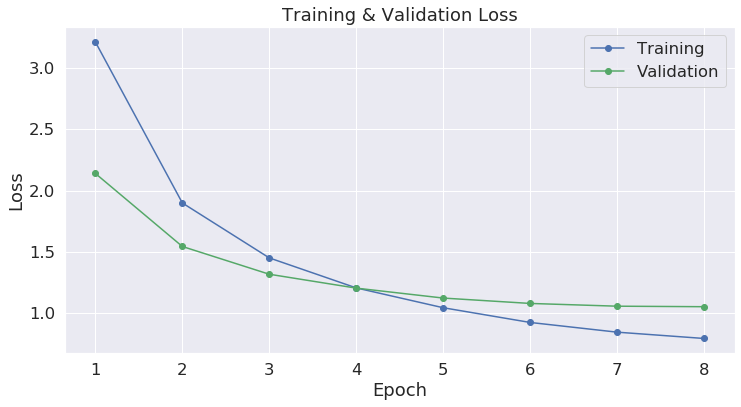

,Training Loss,Valid. Loss,Valid. Accur. per batch,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,3.2132,2.1399,0.5597,0.5599,0:03:35,0:00:08
2,1.8990,1.5439,0.6766,0.6767,0:03:38,0:00:08
3,1.4505,1.3172,0.7113,0.7116,0:03:39,0:00:08
4,1.2056,1.2038,0.7240,0.7244,0:03:38,0:00:08
5,1.0438,1.1228,0.7430,0.7433,0:03:38,0:00:08
6,0.9236,1.0789,0.7447,0.7451,0:03:38,0:00:08
7,0.8444,1.0564,0.7545,0.7549,0:03:39,0:00:08
8,0.7929,1.0522,0.7522,0.7526,0:03:39,0:00:08


In [20]:
_ , stats = res1
exp_1.visual(stats)

■ 훈련 결과 요약

- val loss가 계속 낮아지면서 완만한 기울기로 1.05 값으로 가까워지는 추이를 보이고 있습니다.
- 마지막 epoch 8에 낮은 val loss (1.0522), 높은 val acc (0.7526) 산출 되었습니다.


<br><br>
##### **(2) 실험 2 -  max_length = 128 , batch_size = 64 , lr = 5e-5, epochs = 8**
- lr 변경 : 2e-5 -> 5e-5

In [19]:
exp_2 = Trainer(max_len=128, batch_size=64 , lr= 5e-5, epochs = 8)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [29]:
res2 = exp_2.train()


======== Epoch 1 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:06:13.

  평균 training loss : 2.66
  Training 걸린 시간 : 0:07:32

Validation :
  배치 평균 Accuracy: 0.6087
  ▶ Accuracy: 0.6084
  평균 Validation Loss : 1.7192
  Validation 걸린 시간 : 0:00:17

======== Epoch 2 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:06:14.

  평균 training loss : 1.41
  Training 걸린 시간 : 0:07:33

Validation :
  배치 평균 Accuracy: 0.7052
  ▶ Accuracy: 0.7049
  평균 Validation Loss : 1.2320
  Validation 걸린 시간 : 0:00:17

======== Epoch 3 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:06:14.

  평균 training loss : 1.05
  Training 걸린 시간 : 0:07:32

Validation :
  배치 평균 Accuracy: 0.7399
  ▶ Accuracy: 0.7395
  평균 Validation Loss : 1.0490
  Validation 걸린 시간 : 0:00:17

======== Epoch 4 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:03:25.

  평균 training loss : 0.84
  Training 걸린 시간 : 0:04:04

Validation :
  배치 평균 Accuracy: 0.7576
  ▶ Accuracy: 0.7573
  평균 Va

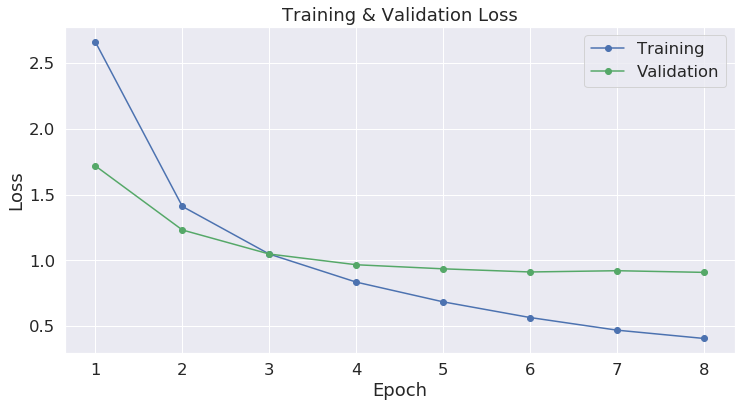

,Training Loss,Valid. Loss,Valid. Accur. per batch,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.6617,1.7192,0.6087,0.6084,0:07:32,0:00:17
2,1.4110,1.2320,0.7052,0.7049,0:07:33,0:00:17
3,1.0485,1.0490,0.7399,0.7395,0:07:32,0:00:17
4,0.8354,0.9675,0.7576,0.7573,0:04:04,0:00:08
5,0.6853,0.9365,0.7728,0.7727,0:03:40,0:00:08
6,0.5659,0.9126,0.7746,0.7744,0:03:40,0:00:08
7,0.4699,0.9221,0.7777,0.7773,0:03:40,0:00:08
8,0.4068,0.9095,0.7799,0.7797,0:03:40,0:00:08


In [34]:
_ , stats = res2
exp_2.visual(stats)

■ 훈련 결과 요약

- lr=2e-5 을 5e-5 로 변경 후 val loss (1.0522->0.9095) 는 더 낮아졌고 , val acc (0.7526->0.7797) 로 더 높아졌습니다. 
(이후 lr=5e-5로 실험 진행)
- epoch 8에 낮은 val loss (0.9095) , 높은 val acc (0.7797) 가 산출 되었습니다.

<br><br>
##### **(3) 실험 3 -  max_length = 256 , batch_size = 64 , lr = 5e-5, epochs = 8**
- max_length 변경 : 128 -> 256
- 메모리 부하 이슈 있었음

In [20]:
exp_3 = Trainer(max_len=256, batch_size=64 , lr=5e-5, epochs = 8)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [27]:
res3 = exp_3.train()


config : max_len=256, batch_size=64, lr=5e-05, epochs = 8, warmup_step=0 

======== Epoch 1 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:05:56.

  평균 training loss : 2.67
  Training 걸린 시간 : 0:07:11

Validation :
  배치 평균 Accuracy: 0.6141
  ▶ Accuracy: 0.6142
  평균 Validation Loss : 1.6808
  Validation 걸린 시간 : 0:00:16

======== Epoch 2 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:05:59.

  평균 training loss : 1.40
  Training 걸린 시간 : 0:07:15

Validation :
  배치 평균 Accuracy: 0.7250
  ▶ Accuracy: 0.7250
  평균 Validation Loss : 1.1885
  Validation 걸린 시간 : 0:00:16

======== Epoch 3 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:06:00.

  평균 training loss : 1.02
  Training 걸린 시간 : 0:07:15

Validation :
  배치 평균 Accuracy: 0.7566
  ▶ Accuracy: 0.7564
  평균 Validation Loss : 1.0162
  Validation 걸린 시간 : 0:00:16

======== Epoch 4 / 8 ========
Training : 
  Batch   400  of    484.    Elapsed: 0:05:59.

  평균 training loss : 0.81
  Training 걸린 시간 : 

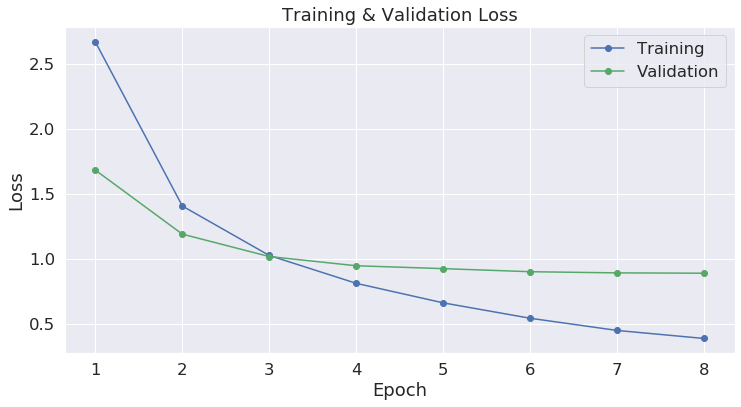

,Training Loss,Valid. Loss,Valid. Accur. per batch,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.6665,1.6808,0.6141,0.6142,0:07:11,0:00:16
2,1.4048,1.1885,0.7250,0.7250,0:07:15,0:00:16
3,1.0244,1.0162,0.7566,0.7564,0:07:15,0:00:16
4,0.8103,0.9455,0.7758,0.7759,0:07:14,0:00:16
5,0.6601,0.9234,0.7731,0.7733,0:07:15,0:00:16
6,0.5417,0.8997,0.7840,0.7840,0:07:15,0:00:16
7,0.4479,0.8907,0.7863,0.7863,0:07:16,0:00:16
8,0.3862,0.8881,0.7877,0.7878,0:07:16,0:00:16


In [28]:
_ , stats = res3
exp_3.visual(stats)

■ 훈련 결과 요약

- max_len을 128 -> 256 로 변경 후 val loss (0.9095->0.8881) 는 더 낮아졌고 , val acc 도 (0.7797->0.7878) 로 더 높아졌습니다. 
(이후 lr=5e-5 로 실험 진행)
- epoch 8에 낮은 val loss (0.8881) , 높은 val acc (0.7878) 가 산출 되었습니다.


<br><br>
##### **(4) 실험 4  -  max_length = 256 , batch_size = 32 , lr = 5e-5, epochs = 8**
- batch_size 를 64 -> 32 로 조정하여 실험

In [19]:
exp_4 = Trainer(max_len=256, batch_size=32 , lr=5e-5, epochs = 8)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [20]:
res4 = exp_4.train()


config : max_len=256, batch_size=32, lr=5e-05, epochs=8, warmup_step=0 

======== Epoch 1 / 8 ========
Training : 
  Batch   400  of    968.    Elapsed: 0:03:08.
  Batch   800  of    968.    Elapsed: 0:06:18.

  평균 training loss : 2.43
  Training 걸린 시간 : 0:07:37

Validation :
  배치 평균 Accuracy: 0.6646
  ▶ Accuracy: 0.6654
  평균 Validation Loss : 1.4287
  Validation 걸린 시간 : 0:00:17

======== Epoch 2 / 8 ========
Training : 
  Batch   400  of    968.    Elapsed: 0:03:10.
  Batch   800  of    968.    Elapsed: 0:06:19.

  평균 training loss : 1.23
  Training 걸린 시간 : 0:07:39

Validation :
  배치 평균 Accuracy: 0.7436
  ▶ Accuracy: 0.7436
  평균 Validation Loss : 1.0740
  Validation 걸린 시간 : 0:00:17

======== Epoch 3 / 8 ========
Training : 
  Batch   400  of    968.    Elapsed: 0:03:10.
  Batch   800  of    968.    Elapsed: 0:06:19.

  평균 training loss : 0.91
  Training 걸린 시간 : 0:07:39

Validation :
  배치 평균 Accuracy: 0.7561
  ▶ Accuracy: 0.7564
  평균 Validation Loss : 0.9423
  Validation 걸린 시간 : 0:00:

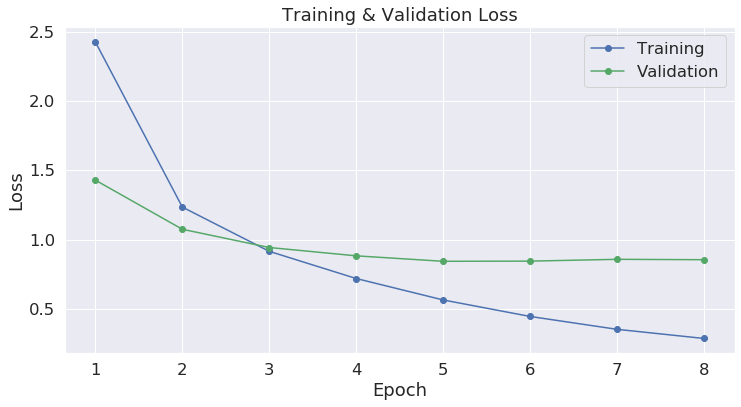

,Training Loss,Valid. Loss,Valid. Accur. per batch,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.4266,1.4287,0.6646,0.6654,0:07:37,0:00:17
2,1.2341,1.0740,0.7436,0.7436,0:07:39,0:00:17
3,0.9144,0.9423,0.7561,0.7564,0:07:39,0:00:17
4,0.7182,0.8821,0.7705,0.7706,0:07:38,0:00:17
5,0.5634,0.8427,0.7844,0.7846,0:07:39,0:00:17
6,0.4442,0.8439,0.7914,0.7919,0:07:40,0:00:17
7,0.3513,0.8570,0.7989,0.7991,0:07:44,0:00:17
8,0.2853,0.8542,0.7977,0.7983,0:07:38,0:00:17


In [22]:
_ , stats = res4
exp_4.visual(stats)

■ 훈련 결과 요약

- batch_size 를 64 -> 32 로 변경 후 best val loss (0.8881->0.8427) 는 더 낮아졌고 , best val acc 도 (0.7878->0.7983) 로 더 높아졌습니다. 
(이후 lr=5e-5 로 실험 진행) 
- epoch 6에 낮은 val loss (0.8427) , epoch 8에 높은 val acc (0.7983) 가 산출 되었습니다.
- max_len 256 에서 32 배치사이즈에서 안정적으로 학습함을 알 수 있습니다.


<br><br>
##### **(5) 실험 5 -  max_length = 512 , batch_size = 16 , lr = 5e-5, epochs = 8**
- max_length 변경 : 256 -> 512

In [19]:
exp_5 = Trainer(max_len=512, batch_size=16 , lr=5e-5, epochs = 8)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [20]:
res5 = exp_5.train()


config : max_len=512, batch_size=16, lr=5e-05, epochs=8, warmup_step=0 

======== Epoch 1 / 8 ========
Training : 
  Batch   400  of  1,935.    Elapsed: 0:03:32.
  Batch   800  of  1,935.    Elapsed: 0:07:05.
  Batch 1,200  of  1,935.    Elapsed: 0:10:39.
  Batch 1,600  of  1,935.    Elapsed: 0:14:13.

  평균 training loss : 2.32
  Training 걸린 시간 : 0:17:12

Validation :
  배치 평균 Accuracy: 0.6404
  ▶ Accuracy: 0.6404
  평균 Validation Loss : 1.4922
  Validation 걸린 시간 : 0:00:39

======== Epoch 2 / 8 ========
Training : 
  Batch   400  of  1,935.    Elapsed: 0:03:34.
  Batch   800  of  1,935.    Elapsed: 0:07:08.
  Batch 1,200  of  1,935.    Elapsed: 0:10:42.
  Batch 1,600  of  1,935.    Elapsed: 0:14:17.

  평균 training loss : 1.25
  Training 걸린 시간 : 0:17:16

Validation :
  배치 평균 Accuracy: 0.7131
  ▶ Accuracy: 0.7131
  평균 Validation Loss : 1.1433
  Validation 걸린 시간 : 0:00:39

======== Epoch 3 / 8 ========
Training : 
  Batch   400  of  1,935.    Elapsed: 0:03:35.
  Batch   800  of  1,935.    

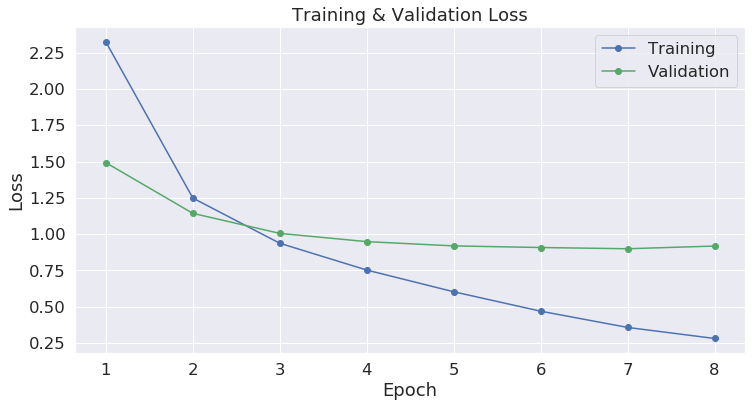

,Training Loss,Valid. Loss,Valid. Accur. per batch,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.3237,1.4922,0.6404,0.6404,0:17:12,0:00:39
2,1.2485,1.1433,0.7131,0.7131,0:17:16,0:00:39
3,0.9372,1.0054,0.7436,0.7436,0:17:21,0:00:39
4,0.7529,0.9486,0.7596,0.7596,0:17:29,0:00:39
5,0.6033,0.9193,0.7692,0.7692,0:17:27,0:00:39
6,0.4696,0.9081,0.7805,0.7805,0:17:32,0:00:39
7,0.3577,0.8996,0.7872,0.7872,0:17:29,0:00:39
8,0.2817,0.9183,0.7904,0.7904,0:17:29,0:00:39


In [22]:
_ , stats = res5
exp_5.visual(stats)

■ 훈련 결과 요약

- max_length 256 -> 512 로 문장길이를 더 늘려 학습을 시킬 경우 더 좋은 결과를 산출하는지 실험해보았습니다. 
- 오히려 best val loss (0.8427->0.9081) 는 더 높아졌고 , best val acc 도 (0.7983->0.7904) 로 낮아졌습니다.  


<br><br>
##### **(6) 실험 6  max_length = 256 , batch_size = 32 , lr = 5e-5, epochs = 8, warmup_step=10**
- 실험5 까지  max_length = 256 , batch_size = 32 , lr = 5e-5 기준에서 val_loss 및 best_acc 성능이 우수하므로 하이퍼 파라미터 고정하여 추가 실험
- warmup_step = 0 -> 10 조정하여 실험

In [18]:
exp_6 = Trainer(max_len=256, batch_size=32 , lr=5e-5, epochs=8, warmup_step=10)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [19]:
res6 = exp_6.train()


config : max_len=256, batch_size=32, lr=5e-05, epochs=8, warmup_step=10 

======== Epoch 1 / 8 ========
Training : 
  Batch   400  of    968.    Elapsed: 0:03:06.
  Batch   800  of    968.    Elapsed: 0:06:15.

  평균 training loss : 2.41
  Training 걸린 시간 : 0:07:34

Validation :
  배치 평균 Accuracy: 0.6557
  ▶ Accuracy: 0.6552
  평균 Validation Loss : 1.4730
  Validation 걸린 시간 : 0:00:17

======== Epoch 2 / 8 ========
Training : 
  Batch   400  of    968.    Elapsed: 0:03:09.
  Batch   800  of    968.    Elapsed: 0:06:18.

  평균 training loss : 1.23
  Training 걸린 시간 : 0:07:37

Validation :
  배치 평균 Accuracy: 0.7326
  ▶ Accuracy: 0.7328
  평균 Validation Loss : 1.1092
  Validation 걸린 시간 : 0:00:17

======== Epoch 3 / 8 ========
Training : 
  Batch   400  of    968.    Elapsed: 0:03:09.
  Batch   800  of    968.    Elapsed: 0:06:17.

  평균 training loss : 0.92
  Training 걸린 시간 : 0:07:36

Validation :
  배치 평균 Accuracy: 0.7546
  ▶ Accuracy: 0.7544
  평균 Validation Loss : 0.9890
  Validation 걸린 시간 : 0:00

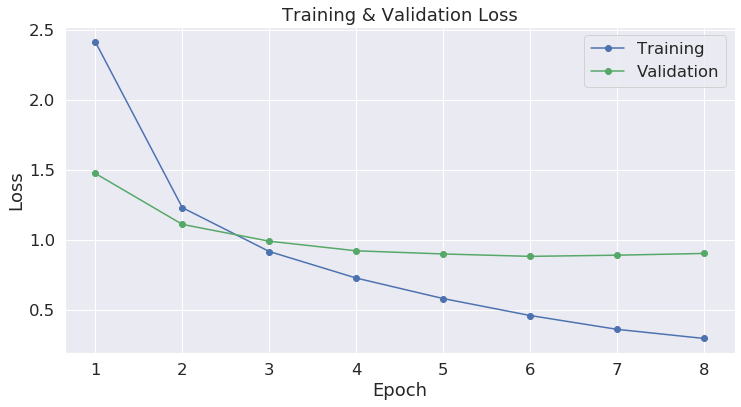

,Training Loss,Valid. Loss,Valid. Accur. per batch,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.4131,1.4730,0.6557,0.6552,0:07:34,0:00:17
2,1.2288,1.1092,0.7326,0.7328,0:07:37,0:00:17
3,0.9152,0.9890,0.7546,0.7544,0:07:36,0:00:17
4,0.7254,0.9203,0.7697,0.7703,0:07:36,0:00:17
5,0.5789,0.8977,0.7740,0.7741,0:07:37,0:00:17
6,0.4577,0.8806,0.7856,0.7858,0:07:37,0:00:17
7,0.3589,0.8890,0.7908,0.7910,0:07:37,0:00:17
8,0.2937,0.9015,0.7922,0.7922,0:07:37,0:00:17


In [21]:
_ , stats = res6
exp_6.visual(stats)

■ 훈련 결과 요약

- max_length = 256 , batch_size = 32 , lr = 5e-5 으로 하이퍼파라메터를 고정하고, warmup_step=10 를 적용할 떄 더 좋은 결과를 산출하는지 실험해보았습니다. 
- best val loss (0.8427->0.8806) 는 낮아지지 않았고 , best val acc 도 (0.7983->0.7922) 로 좋은 결과를 산출하진 않았습니다.  

<br><br><br>
#### ■ 최종요약

* 가장 좋은 성능의 하이퍼 파라메터는 다음과 같습니다. \
 : max_length = 256 , batch_size = 32 , lr = 5e-5 , warmup_step=0
* 이 기준으로 validation set을 모두 학습에 투여한 최종 모델을 만들어 test set 의 정확도를 최종 산출 하도록 합니다.

-------
<br><br><br>
#### (9) Test Set을 통한 최종 성능 평가
> 참고 : Test Set으로 성능 평가 시 **"Validation Set"을 제거하고** 전체 train data로 훈련한 최종 model 파라미터를 이용해 Test 및 성능 평가 해야 합니다. \
> Validation Set 의 목적 : \
> 적절한 하이퍼파라메터를 찾고, 최종 훈련할 Epoch 수를 결정하는 데 사용 목적

#### (9-1) Test data 준비
- train data에서 만들었던 것과 동일하게 적용. (DataLoader 사용)

In [22]:
# 상단에서 test data load 완료 
# test = pd.read_csv("data/test_data.tsv", sep ='\t', header=0, encoding='utf-8', names=['label','text'])

# test set의 text 와 label을 리스트화
test_texts = test.text.values.tolist()
test_labels = test.label.values.tolist()

# label별 정수 인덱스로 매핑
# 상단에서 지정한 label_idx 활용
# label_idx = {j:i for i,j in enumerate(sorted(set(test.label.values.tolist())))}  # dict{ 'ASM14261' : 0 , 'ASM14262' : 1 , ...}  
test_labels = [label_idx[i] for i in test.label.values.tolist()]

print('\nTest Data 개수 :',len(test_labels))
print('\n▶label 정수 인덱스화 예시 :' , test.label.values.tolist()[:3], '->', test_labels[:3] )

# 원본 데이터 개수 체크 
print('\nTraining sentences 개수: {:,}\n'.format(train.shape[0]))
print('Test sentences 개수: {:,}\n'.format(test.shape[0]))


Test Data 개수 : 8327

▶label 정수 인덱스화 예시 : ['ASM14326', 'ASM30034', 'ASM30014'] -> [6, 65, 58]

Training sentences 개수: 34,396

Test sentences 개수: 8,327



In [24]:
import pandas as pd
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler

max_len = 256

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
attention_masks_test = []

# test_texts에 대한 토큰화 시행
for sent in test_texts:
    # `encode_plus` will:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # 문장 단위로 입력
                        truncation=True,
                        add_special_tokens = True, # '[CLS]' 와 '[SEP]' 토큰 추가 
                        max_length = max_len,          # 문장 길이를 300 까지 자르고, 빈곳은 0으로 채웁니다.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # attention_mask 를 생성합니다.
                        return_tensors = 'pt',     # pytorch tensors 형태로 출력합니다.
                   )
    
    # 정수인코딩 된 문장을 리스트로 생성     
    input_ids_test.append(encoded_dict['input_ids'])
    
    # attention mask 생성
    attention_masks_test.append(encoded_dict['attention_mask'])

# 리스트를 토치 텐서로 바꾸기
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
test_labels = torch.tensor(test_labels)

# 배치크기를 지정합니다. 
batch_size = 32

# test data의 배치별 dataloader 생성 
prediction_data = TensorDataset(input_ids_test, attention_masks_test, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

<br><br>
#### (9-2) 최종 모델 훈련 
- validation set 없이, 전체 Train Data 로 학습하여, MODEL의 최종 파라미터를 산출한 후 Test set으로 성능 평가 
- 적용할 hyper parameters 는 다음과 같습니다.
> max_len : 256 \
> batch_size : 32 \
> lr : 5e-5 \
> epochs : 8
- test data 로 각 에포크 마다 정확도 산출해보도록 하였습니다. 
- best loss 와 best acc를 찾도록 합니다.

In [13]:
# 최초 원본 데이터 내 문장 개수 재확인 
print('\nTraining sentences 개수: {:,}\n'.format(train.shape[0]))
print('Test sentences 개수: {:,}\n'.format(test.shape[0]))


Training sentences 개수: 34,396

Test sentences 개수: 8,327



In [14]:
# Train data 토큰화 및 정수 매핑, 패딩 시행
# 위에서 training 시 만들어 둔 input_ids, attention_masks를 그대로 사용해도 좋습니다. (아래 코드 생략 가능)
input_ids = []
attention_masks = []

# train_texts 에 대한 토큰화 시행
for sent in train_texts:
    encoded_dict = tokenizer.encode_plus(
                        sent,                       # 문장 단위로 입력
                        truncation=True,
                        add_special_tokens = True,  # '[CLS]' 와 '[SEP]' 토큰 추가 
                        max_length = max_len,           # 문장 길이를 300 까지 자르고, 빈곳은 0으로 채웁니다.
                        pad_to_max_length = True,
                        return_attention_mask = True, # 5번 attention_mask 를 생성합니다. 
                        return_tensors = 'pt',      #  pytorch tensors 형태로 출력합니다.
                   )
    
    # 정수인코딩 된 문장을 리스트로 생성   
    input_ids.append(encoded_dict['input_ids'])
    
    # attention mask 생성
    attention_masks.append(encoded_dict['attention_mask'])

# 리스트를 토치 텐서로 바꾸기
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

In [30]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
import random
import numpy as np

# 최종 모델을 저장할 파일명 지정 
model_fn = 'google_bert_256_32_last.pth'

# 배치크기를 지정합니다. 
batch_size = 32

# dataset 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# train_dataloader 생성
train_dataloader = DataLoader(
            dataset,  # training data
            sampler = RandomSampler(dataset), # 배치 데이터가 랜덤하게 들어갑니다.
            batch_size = batch_size # 배치 사이즈 지정
        )

# pre-trained 된 모델 로드 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # multilingual 다국어버전 모델 로드
    num_labels = 183, # 183개의 레이블의 정답을 맞춰야 하는 classification task
    output_attentions = False, # 모델의 attentions weights를 반환할 것인지 여부
    output_hidden_states = False, # 모델의 모든 hidden-states를 반환할 것인지 여부
)

# pytorch에게 GPU에서 모델을 실행하도록 지시.
model.cuda()

# optimizer 를 지정합니다.
learning_rate = 5e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # learning_rate로 기본값은 5e-5
                  eps = 1e-8 # adam_epsilon로 기본값은 1e-8. # 엡실론 매개 변수 eps = 1e-8은 학습시 0으로 나누는 것을 방지하기 위한 매우 작은 숫자입니다.
                )

from transformers import get_linear_schedule_with_warmup

# training epochs 지정합니다. BERT 저자는 2 ~ 4 사이 값을 추천합니다. (이유는 오버 피팅을 우려)
epochs = 8

# 전체 training steps는 [batch 수] x [epochs 수]. 
total_steps = len(train_dataloader) * epochs

warmup_step = 0
# learning rate scheduler를 만듭니다.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_step, # 기본값은 0 이고 학습시 조정 대상
                                            num_training_steps = total_steps)



print(f"config : max_len={max_len}, batch_size={batch_size}, lr={learning_rate}, epochs={epochs}, warmup_step={warmup_step} ")
############### 최종 모델 학습 ###############
import random
import numpy as np

# 시드설정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training and validation loss 값을 저장합니다. 
training_stats = []
avg_loss = []

#전체 학습/평가 시간을 측정합니다.
total_t0 = time.time()

# 각 에포크 시 실행
for epoch_i in range(0, epochs):
    
    # =======Training=======
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training : ')

    # training 시간 측정
    t0 = time.time()

    # epoch시작 마다 total loss 리셋
    total_train_loss = 0

    # 모델을 훈련 모드로 전환 (pytorch는 training모드인지 evaluation모드인지 지정하여야 함)
    model.train()

    # 각 배치별 훈련 실행
    for step, batch in enumerate(train_dataloader):

        # 매 40번 배치 마다 진행경과를 출력합니다.
        if step % 500 == 0 and not step == 0:
            # 경과 시간을 분 단위로 계산
            elapsed = format_time(time.time() - t0)
            # 진행 사항 출력
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 각 batch 마다 3개의 pytorch tensors 인풋 포맷이 있습니다.:
        #   batch[0]: input ids 
        #   batch[1]: attention masks
        #   batch[2]: labels 
        # .to(device)를 적용해 GPU 메모리 상에 올립니다.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 이전에 계산 된 그라디언트를 지웁니다. (PyTorch의 그레디언트를 축적하는 기능은 RNNs 학습시 유리하기 때문에 존재, 현재에는 불필요)
        model.zero_grad()        

        # forward 기능을 수행합니다.
        # BertForSequenceClassification 모델의 아웃풋 형식은 사이트 참조 (https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification)
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # 모든 배치에 대한 훈련 손실을 누적합니다.
        # `.item ()`함수를 이용해 텐서에서 파이썬 값으로 반환합니다.
        # 마지막에 평균 손실을 계산하게 됩니다.
        total_train_loss += loss.item()

        # 그레디언트(기울기) 계산을 위해 backward() 수행합니다.
        loss.backward()

        # 그레디언트를 1.0.로 한정하여
        # "그라데이션 폭발" 문제를 방지하도록 합니다.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # the learning rate 등을 참조하여 
        # 계산 된 기울기의 일정 부분을 한 스텝으로 움직여 매개 변수를 업데이트 합니다.
        optimizer.step()

        # learning rate를 업데이터 합니다. (점점 줄어드는 decay 적용됨)
        scheduler.step()

    # 모든 배치에 대한 평균 손실을 계산 합니다.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 한 에포크 당 걸린 시간을 측정 합니다.
    training_time = format_time(time.time() - t0)

    print("")
    print("  평균 training loss : {0:.4f}".format(avg_train_loss))
    print("  Training 걸린 시간 : {:}".format(training_time))
        
    # =======Test=======
    # 각 epoch 마다 training 완료 후 test data를 이용해 정확도(accuracy)를 측정 합니다.
    # 필수사항은 아님 (기존 validation 변수 이용하였음)

    print("")
    print("Test :")

    # validation 시간 측정
    t0 = time.time()

    # 모델을 평가 모드로 전환합니다. 
    model.eval()

    # 변수 지정
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    total_correct_sum = 0
    n_total = 0

    # validation data 로 평가합니다.
    for batch in prediction_dataloader:
        
        # 동일하게 배치마다 3가지 pytorch tensors 가 있습니다. 
        #   batch[0]: input ids 
        #   batch[1]: attention masks
        #   batch[2]: labels 
        # .to(device)를 적용해 GPU 메모리 상에 올립니다.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 그레디언트를 no_grad()로 기능을 닫습니다. 
        with torch.no_grad():        

            # forward 기능을 수행합니다.
            # 동일하게 loss, logits을 아웃풋으로 출력합니다. 
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # validation loss를 누적합니다. 
        total_eval_loss += loss.item()

        # logits and labels을 CPU로 옮깁니다. (gpu메모리를 덜어줍니다.)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 각 배치의 정확도를 계산하고 누적 계산하도록 합니다.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        correct, n  = flat_acc_sum(logits, label_ids)
        total_correct_sum += correct
        n_total += n
        

    # 최종 accuracy 정확도를 계산합니다.
    avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
#     print("  배치 평균 Accuracy: {0:.4f}".format(avg_val_accuracy))
    print("  ▶ Accuracy: {0:.4f}".format(total_correct_sum/n_total))

    # 모든 배치에 대한 평균 손실을 계산합니다. 
    avg_val_loss = total_eval_loss / len(prediction_dataloader)
    avg_loss.append(avg_val_loss)
    
    # test loss 가 가장 작을 때 모델 저장
    if avg_val_loss <= min(avg_loss):
        torch.save(model.state_dict(), model_fn)
   
    # test 평가시 걸린 시간을 측정합니다.
    validation_time = format_time(time.time() - t0)
    
    print("  평균 Test Loss : {0:.4f}".format(avg_val_loss))
    print("  Test 걸린 시간 : {:}".format(validation_time))

    # 각 epoch마다 평균 통계를 기록 합니다.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test. Loss': avg_val_loss,
#             'Test. Accur. per_batch': avg_val_accuracy,
            'Test. Accur.': total_correct_sum/n_total,
            'Training Time': training_time,
            'Test Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 


======== Epoch 1 / 8 ========
Training : 
  Batch   500  of  1,075.    Elapsed: 0:03:54.
  Batch 1,000  of  1,075.    Elapsed: 0:07:52.

  평균 training loss : 2.3239
  Training 걸린 시간 : 0:08:27

Test :
  ▶ Accuracy: 0.6514
  평균 Test Loss : 1.4915
  Test 걸린 시간 : 0:00:43

======== Epoch 2 / 8 ========
Training : 
  Batch   500  of  1,075.    Elapsed: 0:03:54.
  Batch 1,000  of  1,075.    Elapsed: 0:07:50.

  평균 training loss : 1.2133
  Training 걸린 시간 : 0:08:26

Test :
  ▶ Accuracy: 0.7220
  평균 Test Loss : 1.1161
  Test 걸린 시간 : 0:00:44

======== Epoch 3 / 8 ========
Training : 
  Batch   500  of  1,075.    Elapsed: 0:03:56.
  Batch 1,000  of  1,075.    Elapsed: 0:07:53.

  평균 training loss : 0.9036
  Training 걸린 시간 : 0:08:28

Test :
  ▶ Accuracy: 0.7523
  평균 Test Loss : 0.9970
  Test 걸린 시간 : 0:00:44

======== Epoch 4 / 8 ========
Training : 
  Batch   500  of  1,075.    Elapsed: 0:04:00.
  Batch 1,000  of  1,075.    Elapsed: 0:08:00.

  평균 training loss : 0.7124
  Training 걸린 시간 : 0:08:36


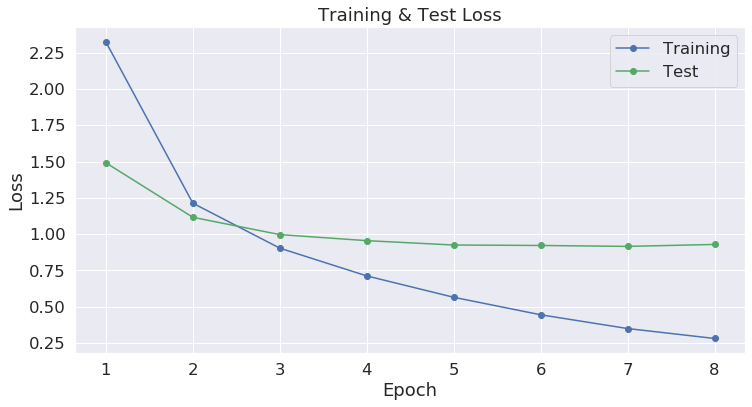

,Training Loss,Test. Loss,Test. Accur.,Training Time,Test Time
epoch,,,,,
1,2.3239,1.4915,0.6514,0:08:27,0:00:43
2,1.2133,1.1161,0.7220,0:08:26,0:00:44
3,0.9036,0.9970,0.7523,0:08:28,0:00:44
4,0.7124,0.9552,0.7607,0:08:36,0:00:44
5,0.5651,0.9252,0.7699,0:08:31,0:00:44
6,0.4447,0.9221,0.7802,0:08:36,0:00:44
7,0.3498,0.9157,0.7804,0:08:29,0:00:44
8,0.2815,0.9293,0.7855,0:08:29,0:00:41


In [32]:
import pandas as pd

# 소수점 두 자리로 표시 
pd.set_option('precision', 4)
# training 통계 결과 값으로 데이터프레임 화
df_stats = pd.DataFrame(data=training_stats)
# 행 단위를 'epoch'로 지정
df_stats = df_stats.set_index('epoch')
# 표 확인
df_stats

# 그래프로 확인
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# seaborn plot 타입 지정
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Test. Loss'], 'g-o', label="Test")

# Label the plot.
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([x for x in range(1,epochs+1)])

plt.show()

df_stats

<br><br>
#### (9-3) Test set으로 정확도 산출

In [33]:
# 최종 저장된 모델 로드
model.load_state_dict(torch.load(model_fn)) 

<All keys matched successfully>

In [36]:
# test set 정확도 산정 
# test data의 배치별 dataloader 생성 
# 최종 저장된 모델 로드
model.load_state_dict(torch.load(model_fn)) 


prediction_data = TensorDataset(input_ids_test, attention_masks_test, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

n_total = 0
total_correct_sum = 0
total_eval_accuracy=0
# 예측 시작 
for batch in prediction_dataloader:
    # GPU에 배치 로드
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # logits and labels을 CPU로 옮깁니다. (gpu메모리를 덜어줍니다.)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 각 배치의 정확도를 계산하고 누적 계산하도록 합니다.
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    correct, n  = flat_acc_sum(logits, label_ids)
    total_correct_sum += correct
    n_total += n
        
# 최종 accuracy 정확도를 계산합니다.
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("================Test Set Accuracy================")
#     print("  배치 평균 Accuracy: {0:.4f}".format(avg_val_accuracy))
print("  ▶ Accuracy: {0:.4f}".format(total_correct_sum/n_total))


Predicting labels for 8,327 test sentences...
================Test Set Accuracy================
  ▶ Accuracy: 0.7804



> po부서의 77.9% 성능에 근접한 78.0%의 test accuracy 가 산출되었습니다. (best_loss기준) \
> best acc 기준으로는 78.55%까지 확인 됩니다.

<br><br><br>
#### (10) lessons learned


- 실험을 많이 할수록 .ipynb의 스크롤이 길어지는 단점이 있었습니다. 
- 이를 위해 <code>클래스</code>와 <code>함수</code>를 이용한 구조체를 활용하였고 다양한 하이퍼파라메터에 대한 반복 실험하는 방식으로 진행하였습니다.
- maxlen, batchsize 및 learning rate에 따라 결과가 차이가 많이 났고 
- 반복적인 실험을 하면서 최적의 하이퍼파라미터를 찾아야 하는 시간적 인내가 필요했습니다.

<br><br><br><br><br><br><br>
<hr>

작성자 : 박은진